# GLOBAL HUNGER CLUSTERING USING SPATIOTEMPORAL DBSCAN
<p align = 'justify'>
ST-DBSCAN (Spatiotemporal Density-Based Spatial Clustering of Applications with Noise) is an extension of the traditional DBSCAN algorithm that incorporates both spatial and temporal dimensions. DBSCAN is a density-based clustering algorithm that groups together data points that are closely packed and separates regions of lower point density. Spatiotemporal DBSCAN extends this concept for datasets that evolve over time.

Here's an overview of Spatiotemporal DBSCAN:

## Basic DBSCAN Concepts:
- Core Points: Points that have a sufficient number of neighbors within a specified radius (eps).
- Border Points: Points that have fewer neighbors than the required density but are within the radius of a core point.
- Noise Points: Points that are neither core nor border points.

## Extension to Spatiotemporal Data:
- Spatial Component: The spatial part of the algorithm remains similar to traditional DBSCAN, considering spatial proximity within a specified distance (eps).
- Temporal Component: Introduces a time parameter to capture the temporal relationship between data points. It considers points within a specified temporal range.

## Parameters:
- eps1 (Spatial Parameter): The maximum distance between two samples for them to be considered as in the same neighborhood.
- eps2 (Temporal Parameter): A specified time window or range within which points are considered neighbors in the temporal dimension.
- min_samples: The minimum number of data points required to form a dense region (core point).

## Package Requirements
- numpy
- pandas
- seaborn
- matplotlib
- scikit-learn
- kneed
- st_dbscan

In [ ]:
#install packages if needed

#!pip install numpy
#!pip install pandas
#!pip install seaborn
#!pip install matplotlib
#!pip install scikit-learn
#!pip install kneed
#!pip install st_dbscan

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors

from st_dbscan import ST_DBSCAN
from sklearn.metrics import silhouette_score

## Dataset
Our data for Undernourishment, Child Stunting, and Women's Anemia are sourced from the UN Statistics Division (UNStats), and for Child Mortality data, we rely on the UN Inter-Agency Group for Child Mortality Estimation (UN IGME).

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
data = pd.read_excel('/content/Data.xlsx') #replace with the data path
data

,Unnamed: 0,GeoAreaName,Region,TimePeriod,Undernourishment,Stunting,Mortality,Anemia
0,0,Afghanistan,Southern Asia,2012,21.0,44.3,80.269673,37.5
1,1,Albania,Southern Europe,2012,4.5,16.4,11.213958,21.6
2,2,Algeria,Northern Africa,2012,3.1,12.1,26.494217,32.9
3,3,Angola,Middle Africa,2012,13.3,31.8,104.875269,45.9
4,4,Argentina,South America,2012,3.3,7.1,13.342989,12.7
...,...,...,...,...,...,...,...,...
1323,1323,Venezuela (Bolivarian Republic of),South America,2019,23.4,10.5,24.229726,24.2
1324,1324,Viet Nam,South-eastern Asia,2019,5.5,21.0,21.063481,20.6
1325,1325,Yemen,Western Asia,2019,38.9,37.6,61.595028,61.5
1326,1326,Zambia,Eastern Africa,2019,29.2,33.2,62.585328,31.5


In [ ]:
data.drop(data.columns[0], axis=1, inplace= True)

In [ ]:
cluster = data.drop(['Region','GeoAreaName'], axis=1)

In [ ]:
cluster = cluster.replace({'TimePeriod' : {
    2012: 0,
    2013: 1,
    2014: 2,
    2015: 3,
    2016: 4,
    2017: 5,
    2018: 6,
    2019: 7
}})
cluster

,TimePeriod,Undernourishment,Stunting,Mortality,Anemia
0,0,21.0,44.3,80.269673,37.5
1,0,4.5,16.4,11.213958,21.6
2,0,3.1,12.1,26.494217,32.9
3,0,13.3,31.8,104.875269,45.9
4,0,3.3,7.1,13.342989,12.7
...,...,...,...,...,...
1323,7,23.4,10.5,24.229726,24.2
1324,7,5.5,21.0,21.063481,20.6
1325,7,38.9,37.6,61.595028,61.5
1326,7,29.2,33.2,62.585328,31.5


In [ ]:
num = ['Undernourishment', 'Stunting', 'Mortality', 'Anemia']
mm = MinMaxScaler()
cluster[num] = mm.fit_transform(cluster[num])
cluster

,TimePeriod,Undernourishment,Stunting,Mortality,Anemia
0,0,0.311005,0.839844,0.534770,0.556377
1,0,0.047847,0.294922,0.061293,0.262477
2,0,0.025518,0.210938,0.166061,0.471349
3,0,0.188198,0.595703,0.703477,0.711645
4,0,0.028708,0.113281,0.075891,0.097967
...,...,...,...,...,...
1323,7,0.349282,0.179688,0.150535,0.310536
1324,7,0.063796,0.384766,0.128826,0.243993
1325,7,0.596491,0.708984,0.406728,1.000000
1326,7,0.441786,0.623047,0.413518,0.445471


## Exploratory Data Analysis

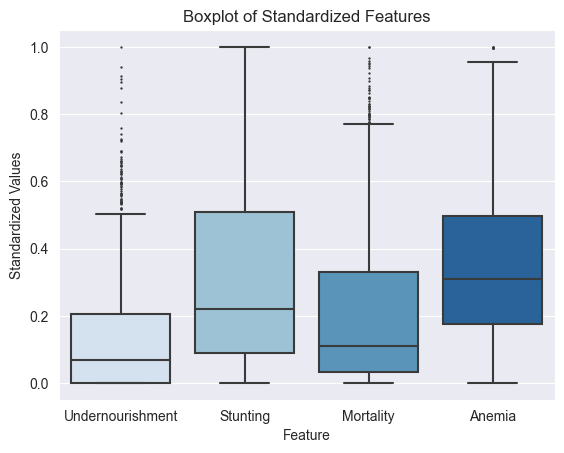

In [ ]:
sns.set_style("darkgrid")

f = sns.boxplot(cluster.iloc[:, 1:], palette='Blues', fliersize=0.8)
f.set(xlabel = 'Feature', ylabel = 'Standardized Values')
f.set_title('Boxplot of Standardized Features')

plt.show()

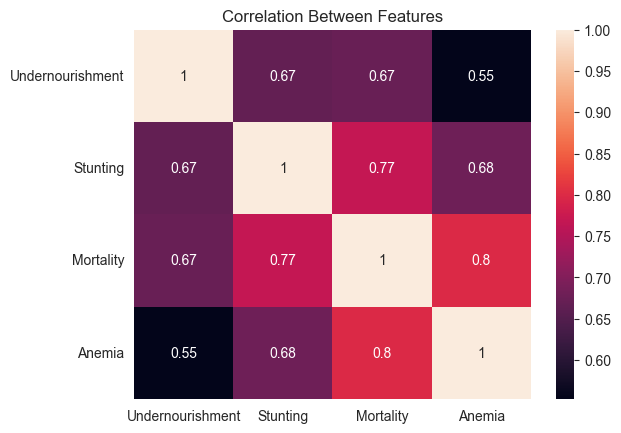

In [ ]:
correlation = cluster.iloc[:, 1:].corr()
f = sns.heatmap(correlation, annot=True)
f.set_title('Correlation Between Features')
plt.yticks(rotation=0)
plt.show()

## ST-DBSCAN Model

To determine the optimal eps1 parameter, we will compute the distances to the k-nearest neighbors (average distance from each data point to its k-nearest neighbors) of an input dataset using the k-nearest neighbor method (unsupervised nearest neighbors learning). To find the k-nearest neighbors, we will use the sklearn.neighbors.NearestNeighbors function.

The NearestNeighbors function requires the n_neighbors parameter, which can be the same as the min_sample parameter + 1, as the kneighbors function also returns the distance of the point to itself.

Then, we will sort the k-th column (distances to the k-th neighbors) and plot the k-NN distance plot. In the k-NN distance plot, we look for the 'knee' or 'elbow' point of the curve to find the optimal value of eps1.

In [ ]:
def max_silhouette(dat, eps2, sample, metric = 'euclidean'):
  silhouette = []

  for j in eps2:
    for k in sample:
      dat_iteration = dat.copy()

      nbrs = NearestNeighbors(n_neighbors = k+1).fit(dat_iteration.iloc[:,1:])
      neigh_dist, neigh_ind = nbrs.kneighbors(dat_iteration.iloc[:,1:])
      sort_neigh_dist = np.sort(neigh_dist, axis = 0)
      k_dist = sort_neigh_dist[:, k]

      kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, curve = "concave", direction = "increasing", online=True)
      i = kneedle.knee_y

      st_dbscan = ST_DBSCAN(eps1 = i, eps2 = j, min_samples = k, metric = metric)
      st_dbscan.fit(dat_iteration)

      labels = st_dbscan.labels
      cluster_result = data.copy()
      cluster_result['Cluster'] = labels

      #counting silhouette
      if len(np.unique(labels)) > 1:
        X = ['Undernourishment', 'Stunting', 'Mortality', 'Anemia']

        score = silhouette_score(cluster_result[X], cluster_result['Cluster'], metric = 'euclidean')
        silhouette.append({'eps1': i, 'eps2': j, 'min_sample': k, 'Silhouette Score': score,
                           'Clusters': len(set(cluster_result[cluster_result['Cluster'] != -1]['Cluster'])),
                           'Outliers': cluster_result[cluster_result['Cluster'] == -1]['Cluster'].count()})

  silhouette = pd.DataFrame(silhouette)
  return(silhouette)

For eps2 and min_samples parameters, we will use the grid search technique. The grid search technique involves iterating through all possible combinations of parameters and saving a model for each combination. To explore the eps2 parameter, we will consider a range from 1 to 7. This range accounts for the 7-year span between the initial observation year (2012) and the final year (2019). For the min_samples parameter, we will explore a range from 3 to 5. Our testing has shown that using a min_sample parameter larger than 5 resulted in oversimplification of the clusters as the algorithm failed to identify smaller, meaningful patterns or subclusters within the data.

In [ ]:
eps2 = range(1, 8)
sample = range(3, 6)

result = max_silhouette(dat = cluster, eps2 = eps2, sample = sample)

To implement this grid search, we pass this list of combinations to the function, which should provide us with the best set of parameters and the best model based on the silhouette score.

In [ ]:
result.sort_values('Silhouette Score', ascending = False).head(10)

,eps1,eps2,min_sample,Silhouette Score,Clusters,Outliers
2,0.154840,1,5,0.250921,8,157
1,0.155948,1,4,0.246709,7,146
0,0.115668,1,3,0.218177,33,4
3,0.115668,2,3,0.078183,29,4
6,0.115668,3,3,0.054974,27,4
9,0.115668,4,3,0.054974,27,4
12,0.115668,5,3,0.035464,26,4
15,0.115668,6,3,0.021406,25,4
18,0.115668,7,3,0.021406,25,4
5,0.154840,2,5,0.005038,20,2


## Clustering Result

The best resulting parameter values were as follows:
<p align = 'center'> eps1 = 0.154840 , eps2 = 1, and min_samples = 5.

With these parameter values, we achieved a Silhouette score of 0.250921. Using the ST-DBSCAN analysis, a total of 8 clusters were formed and 157 data points were detected as outliers.


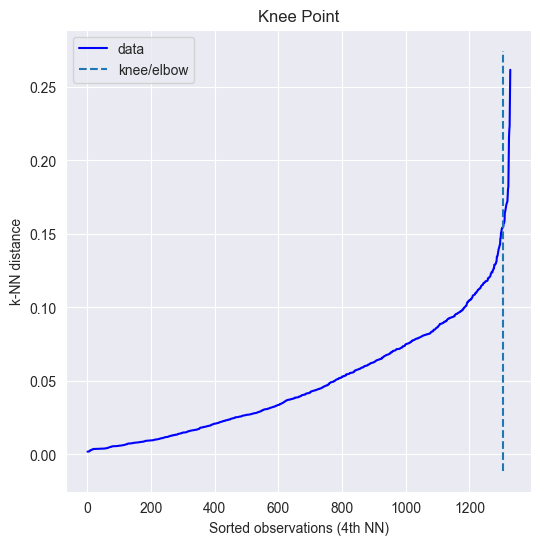

In [ ]:
X = ['Undernourishment', 'Stunting', 'Mortality', 'Anemia']

nbrs = NearestNeighbors(n_neighbors = 6).fit(cluster[X])
neigh_dist, neigh_ind = nbrs.kneighbors(cluster[X])
sort_neigh_dist = np.sort(neigh_dist, axis = 0)
k_dist = sort_neigh_dist[:, 5]

kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, curve = "concave", direction = "increasing", online=True)
kneedle.plot_knee()
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [ ]:
i = kneedle.knee_y

st_dbscan = ST_DBSCAN(eps1 = i, eps2 = 1, min_samples = 5, metric = 'euclidean')
st_dbscan.fit(cluster)

labels = st_dbscan.labels
cluster_result = data.copy()
cluster_result['Cluster'] = labels

score = silhouette_score(pd.DataFrame(cluster_result[X]), cluster_result['Cluster'], metric = 'euclidean')
print('Silhouette Score:', round(score, 4))

Silhouette Score: 0.2509


In [ ]:
cluster_result

,GeoAreaName,Region,TimePeriod,Undernourishment,Stunting,Mortality,Anemia,Cluster
0,Afghanistan,Southern Asia,2012,21.0,44.3,80.269673,37.5,0
1,Albania,Southern Europe,2012,4.5,16.4,11.213958,21.6,0
2,Algeria,Northern Africa,2012,3.1,12.1,26.494217,32.9,0
3,Angola,Middle Africa,2012,13.3,31.8,104.875269,45.9,1
4,Argentina,South America,2012,3.3,7.1,13.342989,12.7,0
...,...,...,...,...,...,...,...,...
1323,Venezuela (Bolivarian Republic of),South America,2019,23.4,10.5,24.229726,24.2,0
1324,Viet Nam,South-eastern Asia,2019,5.5,21.0,21.063481,20.6,0
1325,Yemen,Western Asia,2019,38.9,37.6,61.595028,61.5,-1
1326,Zambia,Eastern Africa,2019,29.2,33.2,62.585328,31.5,0


In [ ]:
cluster_result.to_excel("Cluster.xlsx") #this result will be used for building the dashboard

## Cluster Characteristics

In [ ]:
label_count = pd.DataFrame(cluster_result['Cluster'].value_counts()).reset_index()
label_count.columns = ['Cluster', 'Count']

In [ ]:
cluster_means = pd.DataFrame(cluster_result.iloc[:, 3:].groupby(['Cluster']).mean(numeric_only = True).to_records())
cluster_means = label_count.merge(cluster_means, on = 'Cluster', how = 'right')
cluster_means

,Cluster,Count,Undernourishment,Stunting,Mortality,Anemia
0,-1,157,24.515287,32.663694,68.050452,40.949045
1,0,1058,6.710586,12.804849,20.706306,22.544395
2,1,35,11.642857,30.465714,102.111453,52.205714
3,2,22,14.827273,17.772727,53.915868,53.827273
4,3,16,25.075000,34.118750,129.245230,47.631250
5,4,7,30.371429,42.028571,95.814336,46.614286
6,5,14,35.028571,30.235714,87.790951,45.750000
7,6,12,24.608333,49.083333,53.844436,31.233333
8,7,7,33.028571,40.942857,84.406029,45.114286


In [ ]:
overall_means = round(cluster_result.iloc[:, 3:7].mean(numeric_only = True), 4)
overall_means

Undernourishment    10.0249
Stunting            16.7711
Mortality           32.0451
Anemia              26.8915
dtype: float64